# Fix nearest neighbor problem 

In [4]:
#import packages 
import data_methods as dm
import vis_methods as vm 
import os 
import pandas as pd
import time

import matplotlib.pyplot as plt 
import numpy as np 
import pickle

## Original nn method 

In [9]:
#takes original Frasson file and adds a mean/min/max discharge column 
    #based on nearest neighbor approach (not as-the-crow-flies)
def assign_cop_to_latlon_old(sin_path, dis_path):
    # sin_path = r'D:\MS Sinuosity Data\MS_segments_recovered.xlsx'
    # dis_path = r'D:\CDS River Discharge\Pickles\compressed_ra.pickle'
    
    start_time = time.time() #start a timer 

    #import data , get lat, lon 
    df = pd.read_excel(sin_path)
    dic = pickle.load(open(dis_path, "rb" ) )
    
    lat = dic['lat'].tolist()
    lon = dic['lon'].tolist()
    
    #initialize lists 
    means = []
    maxs = []
    mins = []
    
    #iterate through dataframe from Frasson file and find the closest neighbor within GFAS 
    for ind in df.index:
        
        if ind % 1000 == 0: #print a progress statement 
            print('entry ' + str(ind))
        x = df['lat'][ind]
        y = df['lon'][ind]
        
        ind_x = dm.find_closest_val(x, lat)
        ind_y = dm.find_closest_val(y, lon)
        
        #get mean, max, min from the GFAS file 
        means.append(dic['mean_annual'][ind_x, ind_y])
        maxs.append(dic['peak_annual'][ind_x, ind_y])
        mins.append(dic['min_annual'][ind_x, ind_y])
    
    print('writing new columns to dataframe...')
    #add columns to dataframe 
    df['mean_dis'] = means
    df['min_dis'] = mins
    df['max_dis'] = maxs 
    
    #temporally convert -9999 values to nan, so that they can be processed by np.log
    df[df == -9999.0 ] = np.nan
    
    columns = df.columns.tolist()
    
    #add log columns to dataframe 
    if 'Sinuosity' in columns: df['log_sinuosity'] = np.log(df['Sinuosity'])
    df['log_mw'] = np.log(df['Meandwave'])
    df['log_mean_dis'] = np.log(df['mean_dis'])
    df['log_min_dis'] = np.log(df['min_dis'])
    df['log_max_dis'] = np.log(df['max_dis'])
    if 'QWBM' in columns: df['log_QWBM'] = np.log(df['QWBM'])
    
    #convert nan values back to -9999.0, so this file can be easily shared to non-Python friends 
    df.fillna(-9999.0)
    
    print('rewriting excel file with 9 new columns...')
    #rewrite excel file 
    df = dm.drop_untitled(df)
    df.to_excel(sin_path)
    
    #print time 
    print("--- %s seconds ---" % (time.time() - start_time))

# Run with original 

entry 0
writing new columns to dataframe...
rewriting excel file with 9 new columns...
--- 0.316178560256958 seconds ---
0    2.541058
1    2.541058
Name: mean_dis, dtype: float64


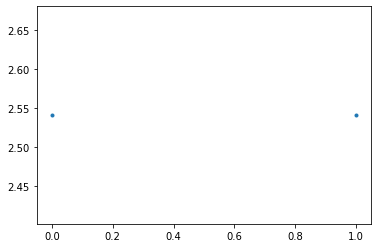

In [19]:
path = r'C:\Users\bydd1\OneDrive\Documents\Research\MS Sinuosity Data\Amazon Segments\Seg9.xlsx'
compressed_discharge_path = r'C:\Users\bydd1\OneDrive\Documents\Research\MS Sinuosity Data\compressed_ra.pickle'  
assign_cop_to_latlon_old(path, compressed_discharge_path)
seg_x = pd.read_excel(path)

plt.figure()
y = seg_x['mean_dis']
print(y)
x = np.arange(0, len(y))
plt.plot(x, y, '.')

## Run with new method (uses grid search scaled to size of average meandwave) 

entry 0
writing new columns to dataframe...
rewriting excel file with 9 new columns...
--- 0.2839956283569336 seconds ---
0    2.541058
1    2.541058
Name: mean_dis, dtype: float64


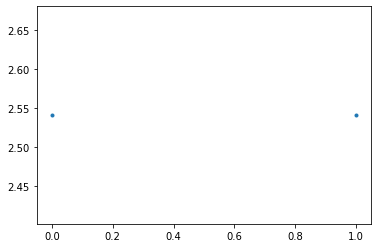

In [20]:
dm.assign_cop_to_latlon(path, compressed_discharge_path)
seg_x = pd.read_excel(path)

plt.figure()
y = seg_x['mean_dis']
print(y)
x = np.arange(0, len(y))
plt.plot(x, y, '.')